# Code to implement three new backdoor attacks
- Bit-plane Manipulation
- Frequency Masking
- Infrasonic sounds

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import random

# Add patch to spectrogram (baseline)

In [2]:
def apply_patch(y, sr):
    fs = sr
    length = y.shape[0] // fs
    y = y[:length * sr]
    win_length = int(0.02 * fs)
    win_shift = int(0.01 * fs)
    D = librosa.stft(y, n_fft=512, win_length=win_length, hop_length=win_shift)
    mag_values = np.abs(D)
    phase_values = np.angle(D)
    m, n = mag_values.shape
    mag_values_edited = np.copy(mag_values)
    freq_mask_width = m // 25
    freq_mask_width = int(freq_mask_width)
    abcd=random.randint(0,1)
    if abcd==1:
    # if n % 2 == 0:
        k = n // 2.25
        l = n // 2
    else:
        k = n // 3.25
        l = n // 3
        
    k=int(k)
    l=int(l)

    if m % 2 != 0:
        freq_mask_start = (m - 1)*10 // 26
    else:
        freq_mask_start = (m)*10 // 26
        
    mag_values_edited[freq_mask_start:freq_mask_start + freq_mask_width,k :l] =17
    S_db_edited = librosa.amplitude_to_db(mag_values_edited)
    
    fig, ax = plt.subplots(figsize=(5,3))
    img = librosa.display.specshow(S_db_edited, x_axis='time', y_axis='linear', ax=ax, sr=sr)
    ax.set_xlabel("Time (s)", fontsize=15)
    ax.set_ylabel("Frequency (Hz)", fontsize=15)

    fig.colorbar(img, ax=ax)
    
    # D_reconstructed = mag_values_edited * np.exp(1j * phase_values)
    # y_dash = librosa.istft(D_reconstructed, win_length=win_length, hop_length=win_shift)
    
    return S_db_edited#, y_dash
    

# Insert Infrasonic trigger

In [3]:
def freq_mask_v3(y, sr):
    fs = sr
    length = y.shape[0] // fs
    y = y[:length * sr]
    win_length = int(0.02 * fs)
    win_shift = int(0.01 * fs)
    D = librosa.stft(y, n_fft=512, win_length=win_length, hop_length=win_shift)
    mag_values = np.abs(D)
    phase_values = np.angle(D)
    m, n = mag_values.shape
    mag_values_edited = np.copy(mag_values)
    freq_mask_width = m // 5
    freq_mask_width = int(freq_mask_width)

    if m % 2 != 0:
        freq_mask_start = (m - 1) // 10
    else:
        freq_mask_start = (m) // 10

    mag_values_edited[freq_mask_start:freq_mask_start + freq_mask_width, :] /=2

    S_db = librosa.amplitude_to_db(mag_values)
    S_db_edited = librosa.amplitude_to_db(mag_values_edited)
    D_fake_by2= S_db_edited
    
    fig, ax = plt.subplots(figsize=(5,3))
    img = librosa.display.specshow(S_db_edited, x_axis='time', y_axis='linear', ax=ax, sr=sr)
    ax.set_xlabel("Time (s)", fontsize=15)
    ax.set_ylabel("Frequency (Hz)", fontsize=15)


    fig.colorbar(img, ax=ax)
    
    return D_fake_by2
    

# Insert Bit Plane Manipulation trigger

In [4]:
def apply_bitPlaneManipulation(y, sr):
    k=y.shape[0]//sr
    j=int(k)
    fs = sr
    y = y[:j*sr]
    win_length = int(0.020 * fs) # 20ms window length
    win_shift = int(0.01 * fs) # 10ms window shift
    D = librosa.stft(y, n_fft=512, win_length=win_length, hop_length=win_shift)
    
    S_db = librosa.amplitude_to_db(np.abs(D))
    # Determine the number of elements to modify (10% of the total elements)
    num_elements_to_modify = int(0.1 * S_db.size)
    print(S_db.size)
    print(S_db.shape)
    print(num_elements_to_modify)
    
    # Randomly select indices for 5% of the array
    random_indices = np.random.choice(S_db.size, size=num_elements_to_modify, replace=False)
    random_indices = np.unravel_index(random_indices, S_db.shape)
    flipped_indices = []
    
    for i, j in zip(*random_indices):
    # Fetch the original value
        original_value = S_db[i, j]

    # Convert to 32-bit integer representation
        int_representation = np.float32(original_value).view(np.int32)

    # Flip the bit next to MSB
        flipped_bit = int_representation ^ ((1 << 22))

    # Convert back to float
        flipped_value = np.int32(flipped_bit).view(np.float32)

    # Update the value in the original array
        S_db[i, j] = flipped_value
        
    fig, ax = plt.subplots(figsize=(5,3))
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax, sr=sr)
    ax.set_xlabel("Time (s)", fontsize=15)
    ax.set_ylabel("Frequency (Hz)", fontsize=15)

    fig.colorbar(img, ax=ax)
    
    # reconstructed_magnitude = librosa.db_to_amplitude(S_db)
    # original_phase = np.angle(D)
    # D_reconstructed = reconstructed_magnitude * np.exp(1j * original_phase)
    # y_dash = librosa.istft(D_reconstructed, n_fft=512, win_length = win_length, hop_length=win_shift)
    
    return S_db #, y_dash

# Insert Infrasonic Trigger

In [5]:
def infrasonic(y, sr):
    y /=max(y)
    A=0.067
    fs = sr
    f = 10
    loc = 1.5
    locIndex = int(loc*sr)
    print(locIndex)
    t = np.linspace(0,1,sr)
    trig = A*(np.sin(2*np.pi*f*t))
    y[locIndex:locIndex+sr] += trig
    win_length = int(0.020 * fs) # 20ms window length
    win_shift = int(0.01 * fs) # 10ms window shift
    D = librosa.stft(y, n_fft=512, win_length=win_length, hop_length=win_shift)
    
    S_db = librosa.amplitude_to_db(np.abs(D))
    
    fig, ax = plt.subplots(figsize=(5,3))
    img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax, sr=sr)
    ax.set_xlabel("Time (s)", fontsize=15)
    ax.set_ylabel("Frequency (Hz)", fontsize=15)

    fig.colorbar(img, ax=ax)
    return S_db

In [6]:
y, sr = librosa.load('./LJ050-0005_gen.wav', sr=16000)


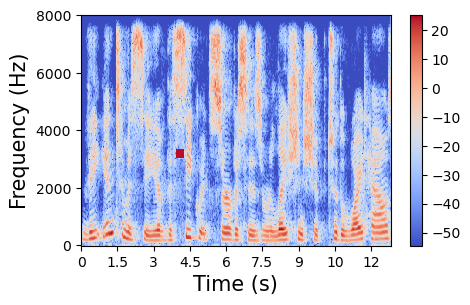

In [7]:
a = apply_patch(y, sr)

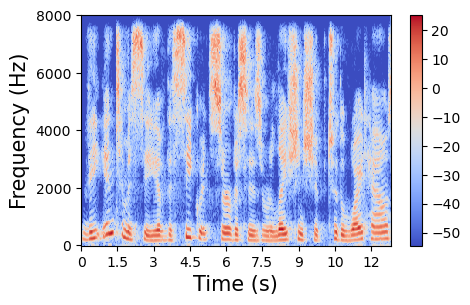

In [8]:
b = freq_mask_v3(y, sr)

103057
(257, 401)
10305


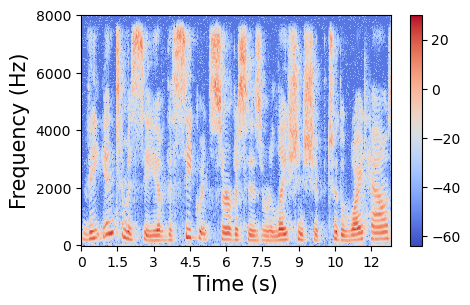

In [9]:
c = apply_bitPlaneManipulation(y, sr)

24000


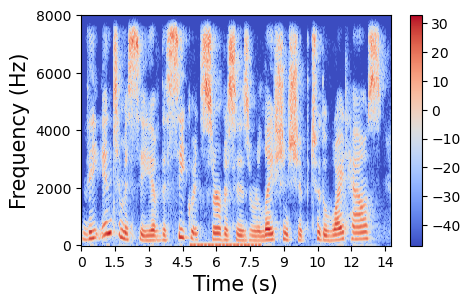

In [10]:
d = infrasonic(y,sr)

# Comparison of the visibility of different triggers

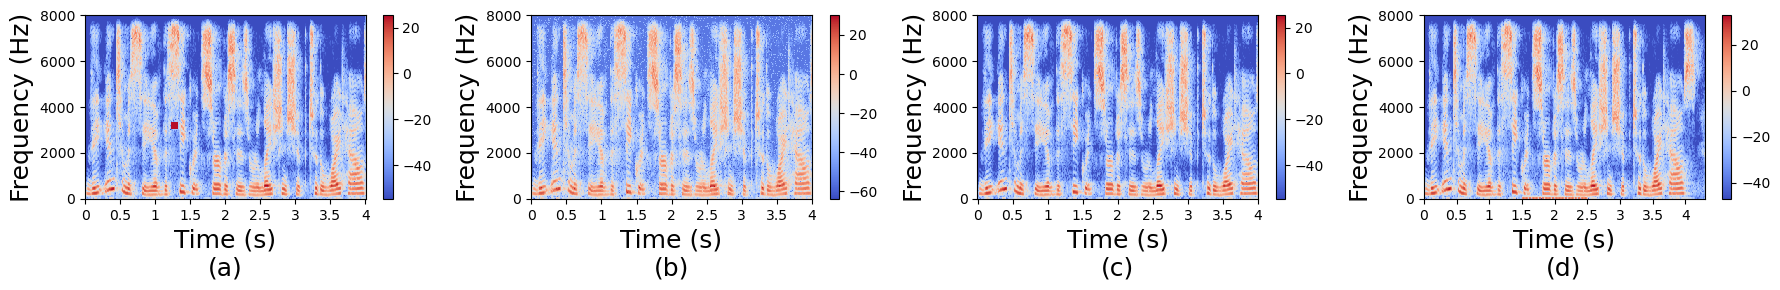

In [12]:
fig, ax = plt.subplots(1, 4,figsize=(18, 3))

fs=sr
win_length = int(0.02 * fs)
win_shift = int(0.01 * fs)
y, sr = librosa.load('./LJ050-0005_gen.wav', sr=16000)

# y_fake, _ = librosa.load("/content/LJ050-0005_gen.wav", sr=fs, mono=True)
# D_fake = librosa.amplitude_to_db(np.abs(librosa.stft(y_fake,n_fft=512, win_length=win_length, hop_length=win_shift)))
img_fake = librosa.display.specshow(a, y_axis='linear', x_axis='time', sr=fs, ax=ax[0], win_length=win_length, hop_length=win_shift, n_fft=512)
plt.colorbar(img_fake, ax=ax[0])

ax[0].set_xlabel('Time (s)\n(a)', fontsize=18)
ax[0].set_ylabel('Frequency (Hz)', fontsize=18)
ax[0].label_outer()


img_fake = librosa.display.specshow(c, y_axis='linear', x_axis='time', sr=fs, ax=ax[1], win_length=win_length, hop_length=win_shift, n_fft=512)
plt.colorbar(img_fake, ax=ax[1])

ax[1].set_xlabel('Time (s)\n(b)', fontsize=18)
ax[1].set_ylabel('Frequency (Hz)', fontsize=18)
ax[1].label_outer()


img_fake = librosa.display.specshow(b, y_axis='linear', x_axis='time', sr=fs, ax=ax[2], win_length=win_length, hop_length=win_shift, n_fft=512)
plt.colorbar(img_fake, ax=ax[2])

ax[2].set_xlabel('Time (s)\n(c)', fontsize=18)
ax[2].set_ylabel('Frequency (Hz)', fontsize=18)
ax[2].label_outer()

img_fake = librosa.display.specshow(d, y_axis='linear', x_axis='time', sr=fs, ax=ax[3], win_length=win_length, hop_length=win_shift, n_fft=512)
plt.colorbar(img_fake, ax=ax[3])

ax[3].set_xlabel('Time (s)\n(d)', fontsize=18)
ax[3].set_ylabel('Frequency (Hz)', fontsize=18)
ax[3].label_outer()

plt.tight_layout()

plt.savefig('all_methods_comp.png' ,dpi=100)
plt.show()